In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from PIL import Image
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fractions import Fraction
font = {'family' : 'Times New Roman',
    'weight' : 'light',
    'size'   : 13,
    }
plt.rc('font',family='Times New Roman')

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

#def curve_color():
def set_axis(axes,xmaj=0.5,xmin=0.125,ymaj=0.5,ymin=0.125,aspect=None):
    if aspect:
        axes.set_aspect(aspect)
    axes.minorticks_on()
    axes.tick_params(axis="both", which="major", direction="in", width=1, length=4, labelsize=10)
    axes.tick_params(axis="both", which="minor", direction="in", width=1, length=2, labelsize=10)

    axes.xaxis.set_major_locator(MultipleLocator(xmaj))
    axes.xaxis.set_minor_locator(MultipleLocator(xmin))
    axes.yaxis.set_major_locator(MultipleLocator(ymaj))
    axes.yaxis.set_minor_locator(MultipleLocator(ymin))

In [2]:
class solver:
    def __init__(self,nx=200,dt=1e-4,gamma=1.4,init_l=np.array([1,0,1]),init_r=np.array([0.125,0,0.1])):
        self.gamma=gamma
        self.nx=nx        
        self.dx=1./nx
        self.dt=dt
        self.x_range=np.arange(0,1.0,self.dx)

        self.u=np.zeros((3,nx))
        self.u1=np.zeros((3,nx))
        rho0l,u0l,p0l=init_l
        rho0r,u0r,p0r=init_r
        self.u1[0]=rho0l*(self.x_range<0.5)+rho0r*(self.x_range>=0.5)
        self.u1[1]=u0l*(self.x_range<0.5)+u0r*(self.x_range>=0.5)
        self.u1[2]=p0l*(self.x_range<0.5)+p0r*(self.x_range>=0.5)
        self.u=self.convert1(self.u1)

    def convert1(self,u1):
        return np.array([u1[0],u1[1]*u1[0],u1[2]/(self.gamma-1)+1/2*u1[0]*u1[1]**2])
    
    def convert2(self,u):
        return np.array([u[0],u[1]/u[0],(self.gamma-1)*(u[2]-u[1]**2/(2*u[0]))])
    
    def Q(self,u):
        pass

    def solve(self,ts=[0.2],entropyfix=False):  
        count=0
        t=0
        sol_list=[]
        while t<ts[-1]:
            if t+self.dt<ts[count]: ddt=self.dt
            else: ddt=ts[count]-t
            u_1=self.u-ddt*self.Q(self.u)
            u_2=3/4*self.u+1/4*(u_1-ddt*self.Q(u_1))
            self.u=1/3*self.u+2/3*(u_2-ddt*self.Q(u_2))
            t+=ddt
            if t==ts[count]:
                sol_list.append(self.convert2(self.u))
                print(1)
                count+=1
        return sol_list
        

In [3]:
class ROE(solver):
    def __init__(self,nx=200,dt=1e-4,gamma=1.4,init_l=np.array([1,0,1]),init_r=np.array([0.125,0,0.1])):
        #print('Method: TVD, nx: {}, dx: {}, dt: {}, dt: {}'.format(self.nx, self.dx, self.nt, self.dt))
        super().__init__(nx,dt,gamma,init_l,init_r)
    
    def roe_average(self,Ul,Ur):
        rhol,ul,pl=self.convert2(Ul)
        rhor,ur,pr=self.convert2(Ur)
        hl,hr=(Ul[2]+pl)/rhol,(Ur[2]+pr)/rhor
        sqrtrhol,sqrtrhor=np.sqrt(rhol),np.sqrt(rhor)
        rr=sqrtrhol*sqrtrhor
        uu=(sqrtrhol*ul+sqrtrhor*ur)/(sqrtrhol+sqrtrhor)
        hh=(sqrtrhol*hl+sqrtrhor*hr)/(sqrtrhol+sqrtrhor)
        a=np.sqrt((self.gamma-1)*(hh-1/2*uu**2))
        return rhol,rhor,ul,ur,pl,pr,rr,uu,hh,a
    
    def roe_flux(self,Ul,Ur):
        def flux(u):
            f=np.zeros_like(u)
            f[0]=u[1]
            f[1]=u[1]**2/u[0]+(self.gamma-1)*(u[2]-u[1]**2/(2*u[0]))
            f[2]=u[1]/u[0]*(u[2]+(self.gamma-1)*(u[2]-u[1]**2/(2*u[0])))
            return f
        rhol,rhor,ul,ur,pl,pr,rr,uu,hh,aa=self.roe_average(Ul,Ur)
        lambda1,lambda2,lambda3=uu-aa,uu,uu+aa
        alpha=np.zeros(3)
        alpha[0]=1/(2*aa**2)*(pr-pl-rr*aa*(ur-ul))
        alpha[1]=rhor-rhol-(pr-pl)/aa**2
        alpha[2]=1/(2*aa**2)*(pr-pl+rr*aa*(ur-ul))
        r1=np.array([1,uu-aa,hh-uu*aa])
        r2=np.array([1,uu,1/2*uu**2])
        r3=np.array([1,uu+aa,hh+uu*aa])
        return 1/2*(flux(Ul)+flux(Ur))\
            -1/2*np.abs(lambda1)*alpha[0]*r1\
            -1/2*np.abs(lambda2)*alpha[1]*r2\
            -1/2*np.abs(lambda3)*alpha[2]*r3
    
    def Q(self,u,entropyfix=False):
        rflux=np.zeros((3,self.nx+1))
        for i in range(1,self.nx):
            rflux[:,i]=self.roe_flux(self.u[:,i-1],self.u[:,i])
        rflux[:,0]=self.roe_flux(self.u[:,0],self.u[:,0])
        rflux[:,-1]=self.roe_flux(self.u[:,-1],self.u[:,-1])
        return (rflux[:,1:]-rflux[:,:-1])/self.dx

In [4]:
class TVD1(ROE):
    def __init__(self, nx=200, dt=1e-4, gamma=1.4, init_l=np.array([1, 0, 1]), init_r=np.array([0.125, 0, 0.1])):
        super().__init__(nx, dt, gamma, init_l, init_r)
        print('Scheme: TVD1, dx: {}, dt: {}'.format(self.dx,self.dt))
    def Q(self,u):
        def minmod(u1,u2):
            return (2*(u1>0)-1)*np.min([np.abs(u1),np.abs(u2)],axis=0)*(u1*u2>0)

        rflux=np.zeros((3,self.nx+1))
        for i in range(1,self.nx):
            if i>1: 
                uL=u[:,i-1]+1/2*minmod(u[:,i]-u[:,i-1],u[:,i-1]-u[:,i-2])
            else:
                uL=u[:,i-1]+1/2*minmod(u[:,i]-u[:,i-1],u[:,i-1]-u[:,i-1])
            if i<self.nx-1:
                uR=u[:,i]-1/2*minmod(u[:,i+1]-u[:,i],u[:,i]-u[:,i-1])
            else:
                uR=u[:,i]-1/2*minmod(u[:,i]-u[:,i],u[:,i]-u[:,i-1])

            rflux[:,i]=self.roe_flux(uL,uR)
        rflux[:,0]=self.roe_flux(u[:,0],u[:,0])
        rflux[:,-1]=self.roe_flux(u[:,-1],u[:,-1])
        return (rflux[:,1:]-rflux[:,:-1])/self.dx
    
class TVD2(ROE):
    def __init__(self, nx=200, dt=1e-4, gamma=1.4, init_l=np.array([1, 0, 1]), init_r=np.array([0.125, 0, 0.1])):
        super().__init__(nx, dt, gamma, init_l, init_r)
        print('Scheme: TVD2, dx: {}, dt: {}'.format(self.dx,self.dt))
    def Q(self,u):
        def minmod(u1,u2):
            return (2*(u1>0)-1)*np.min([np.abs(u1),np.abs(u2)],axis=0)*(u1*u2>0)

        rflux=np.zeros((3,self.nx+1))
        for i in range(1,self.nx):
            R=np.zeros((3,3))
            L=np.zeros((3,3))
            rhol,rhor,ul,ur,pl,pr,rr,uu,hh,aa=self.roe_average(self.u[:,i-1],u[:,i])
            R=np.array([[1,1,1],[uu-aa,uu,uu+aa],[hh-uu*aa,1/2*uu**2,hh+uu*aa]])
            L=1/2*np.array([[(self.gamma-1)*uu**2/(2*aa**2)+uu/aa,-((self.gamma-1)*uu/aa**2+1/aa),(self.gamma-1)/aa**2],
                            [2-(self.gamma-1)*uu**2/aa**2,2*(self.gamma-1)*uu/aa**2,-2*(self.gamma-1)/aa**2],
                            [(self.gamma-1)*uu**2/(2*aa**2)-uu/aa,-((self.gamma-1)*uu/aa**2-1/aa),(self.gamma-1)/aa**2]])
            
            minmod1=L@(u[:,i]-u[:,i-1])
            if i>1: 
                minmod2=L@(u[:,i-1]-u[:,i-2])
            else:
                minmod2=L@(u[:,i-1]-u[:,i-1])
            
            if i<self.nx-1:
                minmod3=L@(u[:,i+1]-u[:,i])
            else:
                minmod3=L@(u[:,i]-u[:,i])
            uL=u[:,i-1]+1/2*R@minmod(minmod1,minmod2)
            uR=u[:,i]-1/2*R@minmod(minmod3,minmod1)
            rflux[:,i]=self.roe_flux(uL,uR)

        rflux[:,0]=self.roe_flux(u[:,0],u[:,0])
        rflux[:,-1]=self.roe_flux(u[:,-1],u[:,-1])
        return (rflux[:,1:]-rflux[:,:-1])/self.dx

In [5]:
nx=200
x_range=np.arange(0,1,1/nx)
Roe=ROE(nx=nx,dt=1e-3)
roe=Roe.solve()[0]

Tvd1=TVD1(nx,dt=1e-3)
tvd1=Tvd1.solve()[0]

Tvd2=TVD2(nx,dt=1e-3)
tvd2=Tvd2.solve()[0]


1
Scheme: TVD1, dx: 0.005, dt: 0.001
1
Scheme: TVD2, dx: 0.005, dt: 0.001
1


In [ ]:
path="./MATLAB/Riemann/rho1.0-0.125,u0,p1.0-0.1/"
def txt_to_vectors(file_path, delimiter=' '):
    vectors = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                try:
                    vector = [float(num) for num in line.split(delimiter)]
                    vectors.append(vector)
                except ValueError:
                    print(f"忽略无效行：{line}")
    return np.array(vectors)

file_path=path+'ExactSol_{:.2f}.txt'.format(0.2)
vectors = txt_to_vectors(file_path)


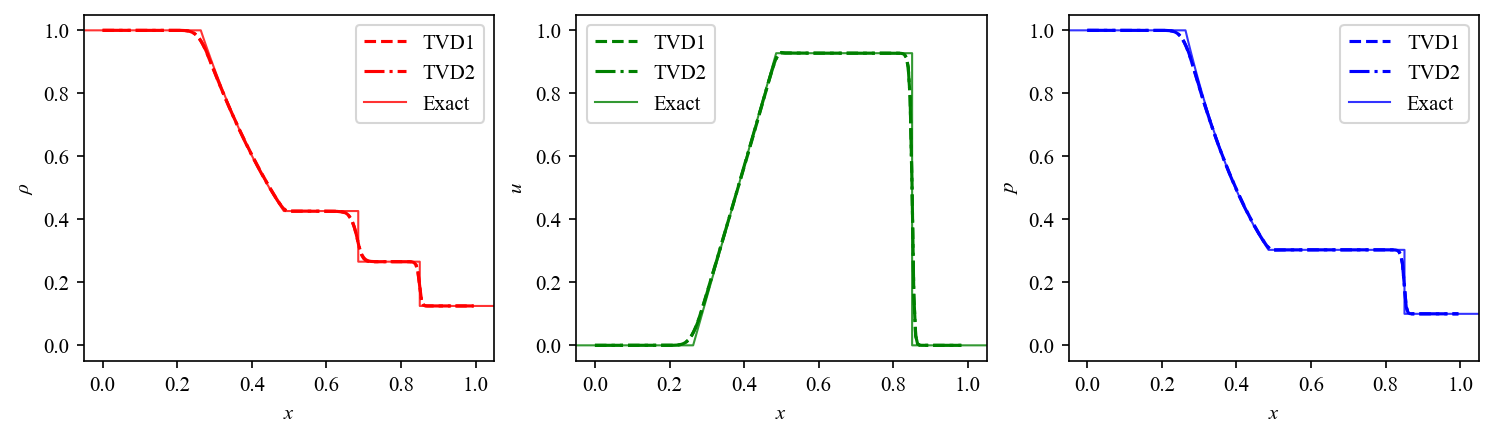

In [ ]:
f,ax=plt.subplots(1,3,dpi=150,figsize=(12,3))
#plt.figure(dpi=150,figsize=(5,3))
ax[0].plot(x_range,tvd1[0],'r--',label='TVD1')#,marker='v',markersize=1)
ax[0].plot(x_range,tvd2[0],'r-.',label='TVD2')#,marker='^',markersize=1)
ax[0].plot(vectors[0]+0.5,vectors[2],'r',label='Exact',alpha=0.8,linewidth=1)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_xlim(-0.05,1.05)
ax[0].set_ylim(-0.05,1.05)
ax[0].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[1].plot(x_range,tvd1[1],'g--',label='TVD1')#,marker='v',markersize=1)
ax[1].plot(x_range,tvd2[1],'g-.',label='TVD2')#,marker='^',markersize=1)
ax[1].plot(vectors[0]+0.5,vectors[1],'g',label='Exact',alpha=0.8,linewidth=1)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u$')
ax[1].set_xlim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
ax[1].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[2].plot(x_range,tvd1[2],'b--',label='TVD1')#,marker='v',markersize=1)
ax[2].plot(x_range,tvd2[2],'b-.',label='TVD2')#,marker='^',markersize=1)
ax[2].plot(vectors[0]+0.5,vectors[3],'b',label='Exact',alpha=0.8,linewidth=1)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$p$')
ax[2].set_xlim(-0.05,1.05)
ax[2].set_ylim(-0.05,1.05)
ax[2].legend()
plt.show()

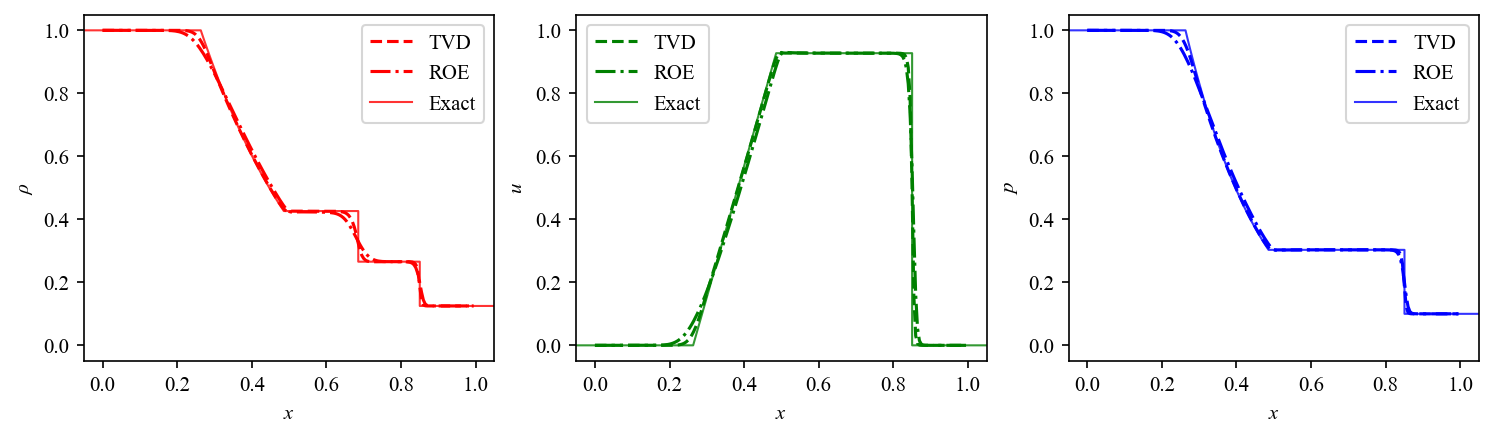

In [8]:

f,ax=plt.subplots(1,3,dpi=150,figsize=(12,3))
#plt.figure(dpi=150,figsize=(5,3))
ax[0].plot(x_range,tvd1[0],'r--',label='TVD')#,marker='v',markersize=1)
ax[0].plot(x_range,roe[0],'r-.',label='ROE')#,marker='^',markersize=1)
ax[0].plot(vectors[0]+0.5,vectors[2],'r',label='Exact',alpha=0.8,linewidth=1)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_xlim(-0.05,1.05)
ax[0].set_ylim(-0.05,1.05)
ax[0].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[1].plot(x_range,tvd1[1],'g--',label='TVD')#,marker='v',markersize=1)
ax[1].plot(x_range,roe[1],'g-.',label='ROE')#,marker='^',markersize=1)
ax[1].plot(vectors[0]+0.5,vectors[1],'g',label='Exact',alpha=0.8,linewidth=1)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u$')
ax[1].set_xlim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
ax[1].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[2].plot(x_range,tvd1[2],'b--',label='TVD')#,marker='v',markersize=1)
ax[2].plot(x_range,roe[2],'b-.',label='ROE')#,marker='^',markersize=1)
ax[2].plot(vectors[0]+0.5,vectors[3],'b',label='Exact',alpha=0.8,linewidth=1)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$p$')
ax[2].set_xlim(-0.05,1.05)
ax[2].set_ylim(-0.05,1.05)
ax[2].legend()
plt.show()

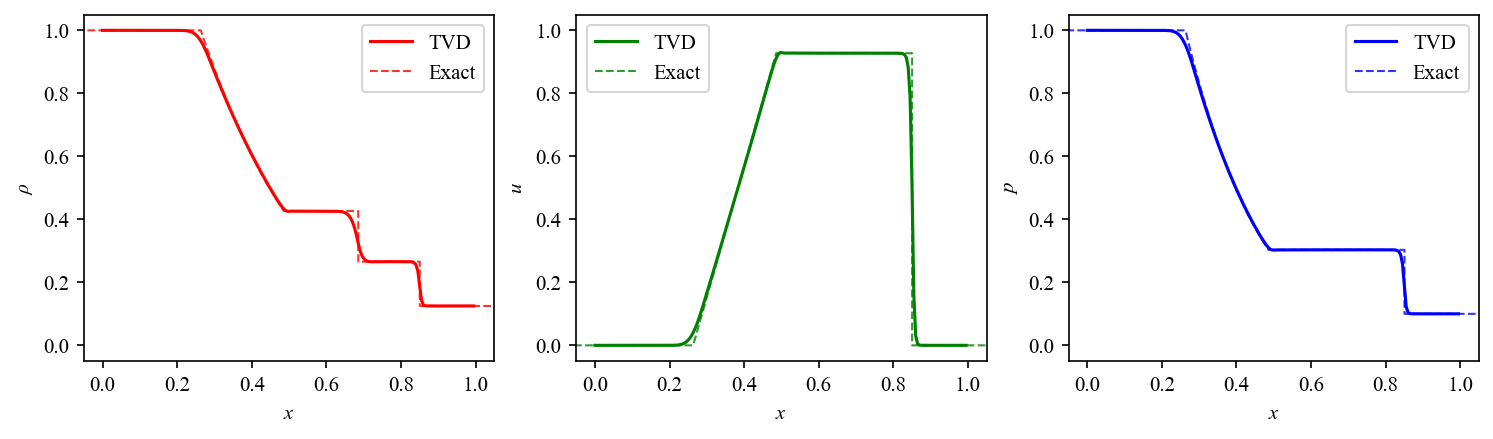

In [9]:
f,ax=plt.subplots(1,3,dpi=150,figsize=(12,3))
#plt.figure(dpi=150,figsize=(5,3))
ax[0].plot(x_range,tvd1[0],'r',label='TVD')#,marker='v',markersize=1)
#ax[0].plot(x_range,roe[0],'r-.',label='ROE')#,marker='^',markersize=1)
ax[0].plot(vectors[0]+0.5,vectors[2],'r--',label='Exact',alpha=0.8,linewidth=1)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_xlim(-0.05,1.05)
ax[0].set_ylim(-0.05,1.05)
ax[0].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[1].plot(x_range,tvd1[1],'g',label='TVD')#,marker='v',markersize=1)
#ax[1].plot(x_range,roe[1],'g-.',label='ROE')#,marker='^',markersize=1)
ax[1].plot(vectors[0]+0.5,vectors[1],'g--',label='Exact',alpha=0.8,linewidth=1)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$u$')
ax[1].set_xlim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
ax[1].legend()
#plt.show()

#plt.figure(dpi=150,figsize=(5,3))
ax[2].plot(x_range,tvd1[2],'b',label='TVD')#,marker='v',markersize=1)
#ax[2].plot(x_range,roe[2],'b-.',label='ROE')#,marker='^',markersize=1)
ax[2].plot(vectors[0]+0.5,vectors[3],'b--',label='Exact',alpha=0.8,linewidth=1)
ax[2].set_xlabel(r'$x$')
ax[2].set_ylabel(r'$p$')
ax[2].set_xlim(-0.05,1.05)
ax[2].set_ylim(-0.05,1.05)
ax[2].legend()
plt.show()